In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

sns.set(rc = {'figure.figsize':(15,8)}, style='white')


In [2]:
train_url="./fraudTrain.csv"
test_url="./fraudTest.csv"

train_df=pd.read_csv(train_url, low_memory=False, index_col=0) #ignore sequencer
test_df=pd.read_csv(test_url, low_memory=False, index_col=0) #ignore sequencer

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-null  i

**Data Dictionary:**

| No. | Field                  | Description                          |
|-----|------------------------|--------------------------------------|
| 1   | trans_date_trans_time  | Transaction time stamp               |
| 2   | cc_num                 | Credit card number                   |
| 3   | merchant               | Merchant name                        |
| 4   | category               | Transaction category                 |
| 5   | amt                    | Transaction amount                   |
| 6   | first                  | First name of card holder            |
| 7   | last                   | Last name of card holder             |
| 8   | gender                 | Sex of card holder                   |
| 9   | street                 | Transaction address                  |
| 10  | city                   | Transaction city                     |
| 11  | state                  | Transaction state                    |
| 12  | zip                    | Transaction zipcode                  |
| 13  | lat                    | Transaction latitude                 |
| 14  | long                   | Transaction longitude                |
| 15  | city_pop               | Population of the city               |
| 16  | job                    | Job of the card holder               |
| 17  | dob                    | Date of birth of card holder         |
| 18  | trans_num              | Transaction number                   |
| 19  | unix_time              | Time in unix format                  |
| 20  | merch_lat              | Latitude of the merchant             |
| 21  | merch_long             | Longitude of the merchant            |
| 22  | is_fraud               | Nature of transaction (fraud or not fraud) |



In [5]:
labels=["Genuine", "Fraud"]

fraud_or_not = train_df["is_fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=train_df['is_fraud'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue", "black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

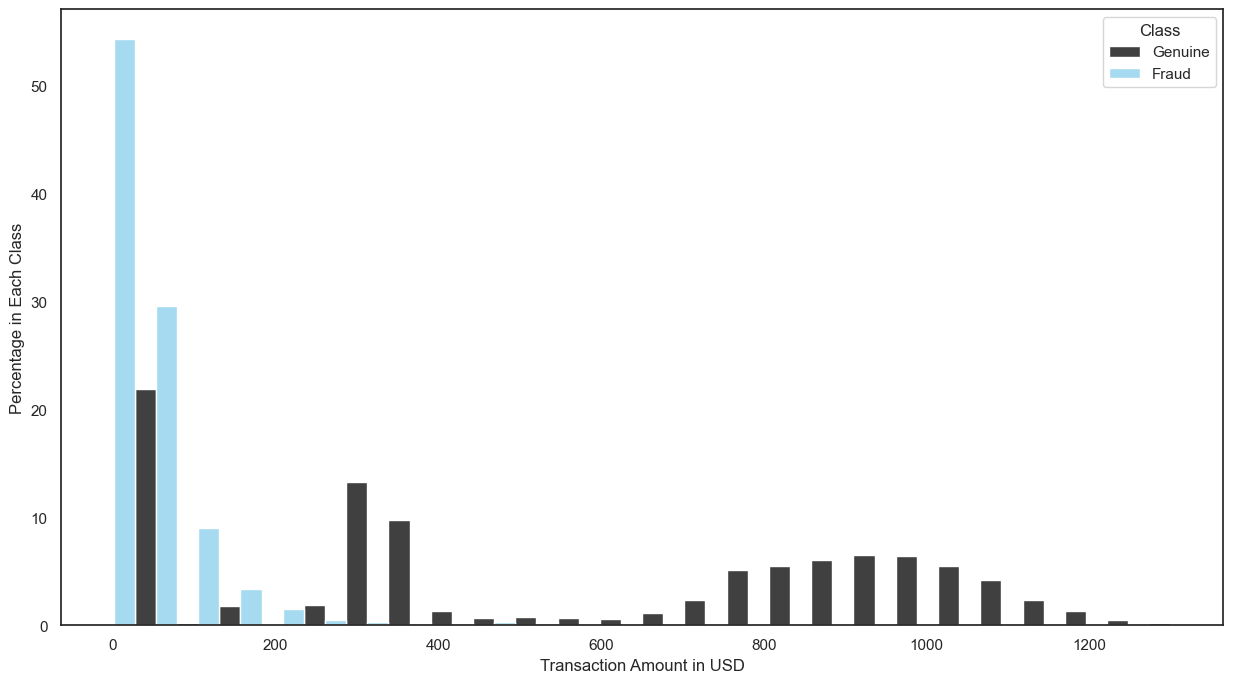

In [6]:
#amount vs fraud
data_subset = train_df[train_df['amt'] <= 1300]
palette = {0: 'skyblue', 1: 'black'}
ax = sns.histplot(data=data_subset, x='amt', hue='is_fraud', stat='percent', multiple='dodge', common_norm=False, bins=25, palette=palette)
ax.set_ylabel('Percentage in Each Class')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Class', labels=['Genuine', 'Fraud'])
plt.show()

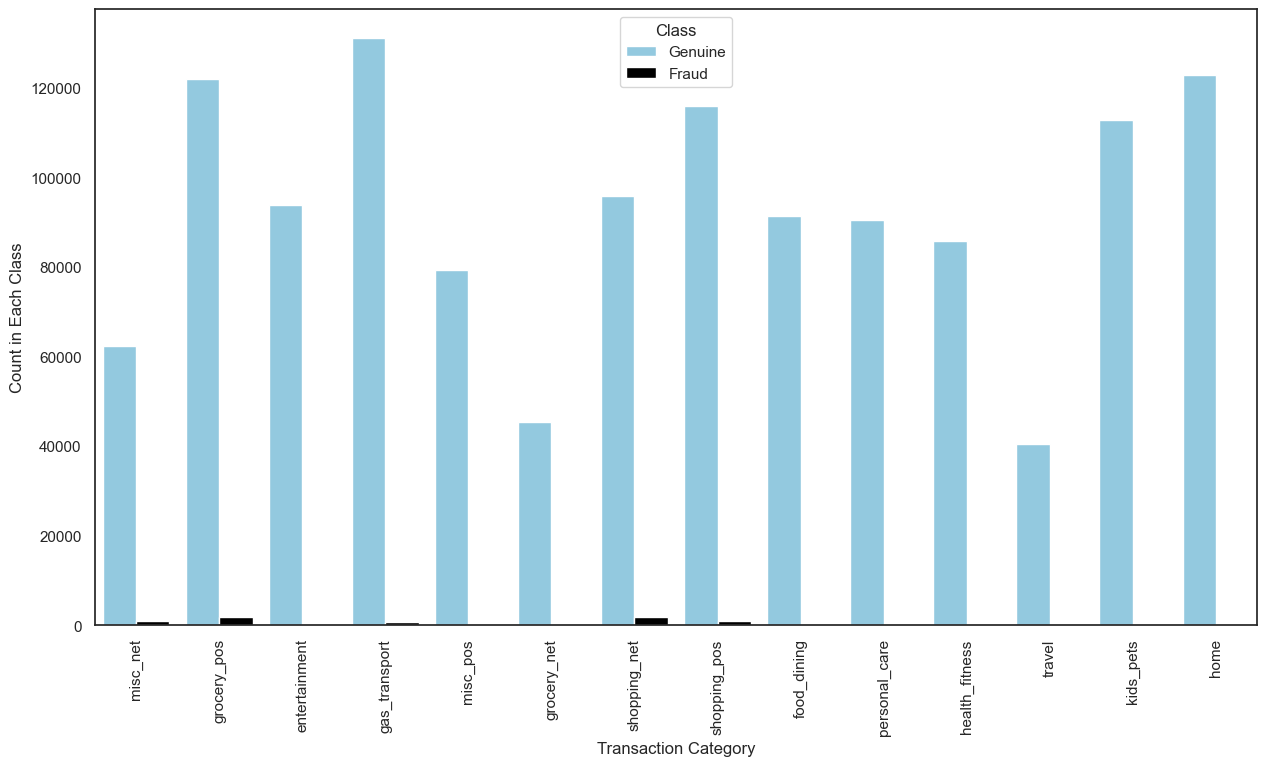

In [7]:
palette = {0: 'skyblue', 1: 'black'}
ax = sns.countplot(x='category', hue='is_fraud', data=train_df, palette=palette)
plt.xticks(rotation=90)
ax.set_ylabel('Count in Each Class')
ax.set_xlabel('Transaction Category')
plt.legend(title='Class', labels=['Genuine', 'Fraud'])
plt.show()

In [8]:
#constructing the merchant-transaction count distribution
df_merchant = train_df[['merchant','trans_num']].groupby(['merchant']).count().reset_index()
df_merchant.columns = ['merchant', 'merchant_count']

#creating the zip-fraud distribution
df_fraud_merchant = train_df[['merchant', 'trans_num', 'is_fraud']].groupby(['merchant','is_fraud']).count().reset_index()
df_fraud_merchant.columns = ['merchant', 'is_fraud', 'Transaction count']

df_fraud_merchant = df_fraud_merchant.merge(df_merchant[['merchant', 'merchant_count']], how='inner', on='merchant')

df_fraud_merchant['Transaction percentage'] = (df_fraud_merchant['Transaction count']/df_fraud_merchant['merchant_count'])*100

#Display the top 20 merchant with high fraudulent transaction volumes
df_fraud_merchant[df_fraud_merchant['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,merchant,is_fraud,Transaction count,merchant_count,Transaction percentage
672,fraud_Kozey-Boehm,1,48,1866,2.572347
489,"fraud_Herman, Treutel and Dickens",1,33,1300,2.538462
606,fraud_Kerluke-Abshire,1,41,1838,2.230686
159,fraud_Brown PLC,1,26,1176,2.210884
400,fraud_Goyette Inc,1,42,1943,2.161606
1220,fraud_Terry-Huel,1,43,1996,2.154309
562,fraud_Jast Ltd,1,42,1953,2.150538
1100,"fraud_Schmeler, Bashirian and Price",1,41,1968,2.083333
145,fraud_Boyer-Reichert,1,38,1908,1.991614
742,"fraud_Langworth, Boehm and Gulgowski",1,39,1969,1.980701
